In [1]:
import pandas as pd
from pathlib import Path
import os
from collections import defaultdict

## Load CSV Files and Dataset Root

In [2]:
# Define paths
dataset_root = Path("/home/bowen68/projects/fish/dinov3/datasets/fishnet")
ann_root = Path("/home/bowen68/projects/fish/dinov3/datasets/anns")

train_csv = ann_root / "train.csv"
test_csv = ann_root / "test.csv"

# Load CSV files
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print(f"Train CSV shape: {train_df.shape}")
print(f"Test CSV shape: {test_df.shape}")
print(f"\nTrain columns: {list(train_df.columns)}")
print(f"\nFirst few image entries:")
print(train_df[['image', 'Folder', 'source']].head(10))

Train CSV shape: (75631, 25)
Test CSV shape: (18901, 25)

Train columns: ['Unnamed: 0.1', 'Unnamed: 0', 'species', 'image', 'SpecCode', 'Genus', 'Subfamily', 'Family', 'Order', 'Class', 'SuperClass', 'source', 'Folder', 'Troph', 'FeedingPath', 'Tropical', 'Temperate', 'Subtropical', 'Boreal', 'Polar', 'freshwater', 'saltwater', 'brackish', 'NewOrder', 'Frequency']

First few image entries:
                                               image      Folder    source
0           1cc71197-f08c-4f99-acf1-623327a89077.jpg    Sparidae      inat
1           aa3ca308-f595-4019-8bff-422c3350a65a.jpg  Sciaenidae      inat
2  https://www.fishbase.se/images/species/Eqiwa_u...  Sciaenidae  fishbase
3  https://www.fishbase.se/images/species/Nimac_u...  Sciaenidae  fishbase
4           3b162191-0a8a-4de7-887e-5c7d79ac36e8.jpg  Sciaenidae      inat
5           89467f81-53ee-4f6d-ba04-15067597c9e9.jpg  Sciaenidae      inat
6           aa03f0c6-6160-4041-a292-1a290d40e8de.jpg  Sciaenidae      inat
7      

## Function to Extract Image Name from URL or Path

In [3]:
def extract_image_name(image_entry):
    """
    Extract the actual image filename from CSV entry.
    - If it starts with 'http', extract the last part after '/' (filename.jpg)
    - Otherwise, use the entry as-is
    """
    if pd.isna(image_entry) or image_entry == '':
        return None
    
    image_entry = str(image_entry)
    
    # If it's a URL, extract just the filename
    if image_entry.startswith('http'):
        return image_entry.split('/')[-1]
    
    return image_entry

# Test the function
test_cases = [
    "1cc71197-f08c-4f99-acf1-623327a89077.jpg",
    "https://www.fishbase.se/images/species/Eqiwa_u0.jpg",
    "https://www.fishbase.se/images/species/Nimac_u1.jpg"
]

print("Testing extract_image_name function:")
for test in test_cases:
    result = extract_image_name(test)
    print(f"  {test[:50]:50} -> {result}")

Testing extract_image_name function:
  1cc71197-f08c-4f99-acf1-623327a89077.jpg           -> 1cc71197-f08c-4f99-acf1-623327a89077.jpg
  https://www.fishbase.se/images/species/Eqiwa_u0.jp -> Eqiwa_u0.jpg
  https://www.fishbase.se/images/species/Nimac_u1.jp -> Nimac_u1.jpg


## Check Image Existence for Train CSV

In [4]:
def check_image_existence(df, dataset_root, split_name=""):
    """
    Check how many images in the CSV actually exist in the dataset folders.
    """
    stats = {
        'total_rows': len(df),
        'rows_with_image': 0,
        'rows_with_folder': 0,
        'valid_rows': 0,
        'found_images': 0,
        'missing_images': 0,
        'url_images': 0,
        'local_images': 0,
    }
    
    missing_details = []
    found_details = []
    
    for idx, row in df.iterrows():
        image_entry = row.get('image', None)
        folder = row.get('Folder', None)
        
        # Skip empty entries
        if pd.isna(image_entry) or image_entry == '':
            continue
        
        stats['rows_with_image'] += 1
        
        if pd.isna(folder) or folder == '':
            continue
            
        stats['rows_with_folder'] += 1
        stats['valid_rows'] += 1
        
        # Extract actual filename
        image_name = extract_image_name(image_entry)
        
        if image_name is None:
            continue
        
        # Track if it was a URL
        if str(image_entry).startswith('http'):
            stats['url_images'] += 1
        else:
            stats['local_images'] += 1
        
        # Check if file exists
        image_path = dataset_root / folder / image_name
        
        if image_path.exists():
            stats['found_images'] += 1
            if len(found_details) < 5:  # Keep first 5 examples
                found_details.append({
                    'csv_entry': str(image_entry)[:60],
                    'extracted': image_name,
                    'folder': folder,
                    'exists': True
                })
        else:
            stats['missing_images'] += 1
            if len(missing_details) < 10:  # Keep first 10 examples
                missing_details.append({
                    'csv_entry': str(image_entry)[:60],
                    'extracted': image_name,
                    'folder': folder,
                    'expected_path': str(image_path)
                })
    
    # Print results
    print(f"\n{'='*70}")
    print(f"Image Existence Check: {split_name}")
    print(f"{'='*70}")
    print(f"Total rows in CSV:                {stats['total_rows']:,}")
    print(f"Rows with image entry:            {stats['rows_with_image']:,}")
    print(f"Rows with folder entry:           {stats['rows_with_folder']:,}")
    print(f"Valid rows (both image & folder): {stats['valid_rows']:,}")
    print(f"\nImage types:")
    print(f"  - URL images (from fishbase):   {stats['url_images']:,}")
    print(f"  - Local images (from inat):     {stats['local_images']:,}")
    print(f"\nFile existence:")
    print(f"  - Found on disk:                {stats['found_images']:,} ({100*stats['found_images']/max(stats['valid_rows'],1):.1f}%)")
    print(f"  - Missing from disk:            {stats['missing_images']:,} ({100*stats['missing_images']/max(stats['valid_rows'],1):.1f}%)")
    
    if found_details:
        print(f"\nFirst few FOUND images:")
        for detail in found_details:
            print(f"  CSV: {detail['csv_entry']}")
            print(f"  -> {detail['folder']}/{detail['extracted']}")
    
    if missing_details:
        print(f"\nFirst few MISSING images:")
        for detail in missing_details:
            print(f"  CSV: {detail['csv_entry']}")
            print(f"  -> Expected: {detail['expected_path']}")
    
    return stats, missing_details

# Check train set
train_stats, train_missing = check_image_existence(train_df, dataset_root, "TRAIN")


Image Existence Check: TRAIN
Total rows in CSV:                75,631
Rows with image entry:            75,631
Rows with folder entry:           75,631
Valid rows (both image & folder): 75,631

Image types:
  - URL images (from fishbase):   35,031
  - Local images (from inat):     40,600

File existence:
  - Found on disk:                75,631 (100.0%)
  - Missing from disk:            0 (0.0%)

First few FOUND images:
  CSV: 1cc71197-f08c-4f99-acf1-623327a89077.jpg
  -> Sparidae/1cc71197-f08c-4f99-acf1-623327a89077.jpg
  CSV: aa3ca308-f595-4019-8bff-422c3350a65a.jpg
  -> Sciaenidae/aa3ca308-f595-4019-8bff-422c3350a65a.jpg
  CSV: https://www.fishbase.se/images/species/Eqiwa_u0.jpg
  -> Sciaenidae/Eqiwa_u0.jpg
  CSV: https://www.fishbase.se/images/species/Nimac_u1.jpg
  -> Sciaenidae/Nimac_u1.jpg
  CSV: 3b162191-0a8a-4de7-887e-5c7d79ac36e8.jpg
  -> Sciaenidae/3b162191-0a8a-4de7-887e-5c7d79ac36e8.jpg


## Check Image Existence for Test CSV

In [5]:
# Check test set
test_stats, test_missing = check_image_existence(test_df, dataset_root, "TEST")


Image Existence Check: TEST
Total rows in CSV:                18,901
Rows with image entry:            18,901
Rows with folder entry:           18,901
Valid rows (both image & folder): 18,901

Image types:
  - URL images (from fishbase):   8,495
  - Local images (from inat):     10,406

File existence:
  - Found on disk:                18,901 (100.0%)
  - Missing from disk:            0 (0.0%)

First few FOUND images:
  CSV: ce230657-448a-491b-ad57-4522e753d738.jpg
  -> Sparidae/ce230657-448a-491b-ad57-4522e753d738.jpg
  CSV: 03bbd564-5501-471b-85d4-ddd84fa2d66b.jpg
  -> Sciaenidae/03bbd564-5501-471b-85d4-ddd84fa2d66b.jpg
  CSV: a1550003-2c81-4028-af80-89b8c5dffff9.jpg
  -> Sciaenidae/a1550003-2c81-4028-af80-89b8c5dffff9.jpg
  CSV: c0edc04f-7879-4db1-8bc8-a43698734d81.jpg
  -> Sciaenidae/c0edc04f-7879-4db1-8bc8-a43698734d81.jpg
  CSV: 9e9c6c01-b78d-4e7a-8623-c5542986758c.jpg
  -> Sciaenidae/9e9c6c01-b78d-4e7a-8623-c5542986758c.jpg


## Summary Statistics

In [6]:
print(f"\n{'='*70}")
print(f"OVERALL SUMMARY")
print(f"{'='*70}")
print(f"\nTRAIN SET:")
print(f"  Total valid entries: {train_stats['valid_rows']:,}")
print(f"  Found: {train_stats['found_images']:,} ({100*train_stats['found_images']/max(train_stats['valid_rows'],1):.2f}%)")
print(f"  Missing: {train_stats['missing_images']:,} ({100*train_stats['missing_images']/max(train_stats['valid_rows'],1):.2f}%)")

print(f"\nTEST SET:")
print(f"  Total valid entries: {test_stats['valid_rows']:,}")
print(f"  Found: {test_stats['found_images']:,} ({100*test_stats['found_images']/max(test_stats['valid_rows'],1):.2f}%)")
print(f"  Missing: {test_stats['missing_images']:,} ({100*test_stats['missing_images']/max(test_stats['valid_rows'],1):.2f}%)")

print(f"\nCOMBINED:")
total_valid = train_stats['valid_rows'] + test_stats['valid_rows']
total_found = train_stats['found_images'] + test_stats['found_images']
total_missing = train_stats['missing_images'] + test_stats['missing_images']
print(f"  Total valid entries: {total_valid:,}")
print(f"  Found: {total_found:,} ({100*total_found/max(total_valid,1):.2f}%)")
print(f"  Missing: {total_missing:,} ({100*total_missing/max(total_valid,1):.2f}%)")
print(f"{'='*70}")


OVERALL SUMMARY

TRAIN SET:
  Total valid entries: 75,631
  Found: 75,631 (100.00%)
  Missing: 0 (0.00%)

TEST SET:
  Total valid entries: 18,901
  Found: 18,901 (100.00%)
  Missing: 0 (0.00%)

COMBINED:
  Total valid entries: 94,532
  Found: 94,532 (100.00%)
  Missing: 0 (0.00%)


## Family Distribution Analysis

In [7]:
# Analyze family distribution in train and test sets
def analyze_family_distribution(df, split_name):
    """Analyze the distribution of families in the dataset."""
    # Count images per family
    family_counts = df['Folder'].value_counts().sort_values(ascending=False)
    
    print(f"\n{'='*70}")
    print(f"Family Distribution Analysis: {split_name}")
    print(f"{'='*70}")
    print(f"Total families: {len(family_counts)}")
    print(f"Total images: {len(df)}")
    print(f"Average images per family: {len(df) / len(family_counts):.2f}")
    print(f"Median images per family: {family_counts.median():.0f}")
    
    # Find families with specific thresholds
    families_1 = family_counts[family_counts == 1]
    families_2to4 = family_counts[(family_counts >= 2) & (family_counts <= 4)]
    families_5to9 = family_counts[(family_counts >= 5) & (family_counts <= 9)]
    families_10to19 = family_counts[(family_counts >= 10) & (family_counts <= 19)]
    families_20plus = family_counts[family_counts >= 20]
    
    print(f"\nDistribution by image count:")
    print(f"  Families with exactly 1 image:   {len(families_1):4d} families")
    print(f"  Families with 2-4 images:        {len(families_2to4):4d} families")
    print(f"  Families with 5-9 images:        {len(families_5to9):4d} families")
    print(f"  Families with 10-19 images:      {len(families_10to19):4d} families")
    print(f"  Families with 20+ images:        {len(families_20plus):4d} families")
    
    # Show top 20 families
    print(f"\nTop 20 families by image count:")
    for i, (family, count) in enumerate(family_counts.head(20).items(), 1):
        print(f"  {i:2d}. {family:30s} {count:5d} images")
    
    # Show families with 1 image
    if len(families_1) > 0:
        print(f"\nFamilies with exactly 1 image ({len(families_1)} total):")
        for family, count in families_1.items():
            print(f"  - {family}")
    
    # Show families with 2-4 images
    if len(families_2to4) > 0:
        print(f"\nFamilies with 2-4 images ({len(families_2to4)} total):")
        for family, count in families_2to4.items():
            print(f"  - {family:30s} {count} images")
    
    return family_counts

# Analyze train set
train_family_counts = analyze_family_distribution(train_df, "TRAIN")


Family Distribution Analysis: TRAIN
Total families: 463
Total images: 75631
Average images per family: 163.35
Median images per family: 25

Distribution by image count:
  Families with exactly 1 image:      0 families
  Families with 2-4 images:          24 families
  Families with 5-9 images:          91 families
  Families with 10-19 images:        88 families
  Families with 20+ images:         260 families

Top 20 families by image count:
   1. Labridae                        4782 images
   2. Pomacentridae                   3430 images
   3. Cyprinidae                      3354 images
   4. Centrarchidae                   2908 images
   5. Gobiidae                        2540 images
   6. Cichlidae                       2302 images
   7. Sparidae                        1876 images
   8. Salmonidae                      1833 images
   9. Serranidae                      1828 images
  10. Acanthuridae                    1446 images
  11. Syngnathidae                    1356 images
  

In [8]:
# Analyze test set
test_family_counts = analyze_family_distribution(test_df, "TEST")


Family Distribution Analysis: TEST
Total families: 463
Total images: 18901
Average images per family: 40.82
Median images per family: 6

Distribution by image count:
  Families with exactly 1 image:     64 families
  Families with 2-4 images:         129 families
  Families with 5-9 images:          87 families
  Families with 10-19 images:        54 families
  Families with 20+ images:         129 families

Top 20 families by image count:
   1. Labridae                        1196 images
   2. Pomacentridae                    858 images
   3. Cyprinidae                       838 images
   4. Centrarchidae                    727 images
   5. Gobiidae                         635 images
   6. Cichlidae                        576 images
   7. Sparidae                         469 images
   8. Salmonidae                       458 images
   9. Serranidae                       457 images
  10. Acanthuridae                     361 images
  11. Syngnathidae                     339 images
  12.

## Combined Train + Test Distribution

In [9]:
# Combine train and test to see overall distribution
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_family_counts = analyze_family_distribution(combined_df, "COMBINED (Train + Test)")


Family Distribution Analysis: COMBINED (Train + Test)
Total families: 463
Total images: 94532
Average images per family: 204.17
Median images per family: 31

Distribution by image count:
  Families with exactly 1 image:      0 families
  Families with 2-4 images:           0 families
  Families with 5-9 images:          91 families
  Families with 10-19 images:        87 families
  Families with 20+ images:         285 families

Top 20 families by image count:
   1. Labridae                        5978 images
   2. Pomacentridae                   4288 images
   3. Cyprinidae                      4192 images
   4. Centrarchidae                   3635 images
   5. Gobiidae                        3175 images
   6. Cichlidae                       2878 images
   7. Sparidae                        2345 images
   8. Salmonidae                      2291 images
   9. Serranidae                      2285 images
  10. Acanthuridae                    1807 images
  11. Syngnathidae                

## Cross-Check: Families in Train vs Test

In [10]:
# Check overlap between train and test families
train_families = set(train_df['Folder'].unique())
test_families = set(test_df['Folder'].unique())

common_families = train_families & test_families
train_only = train_families - test_families
test_only = test_families - train_families

print(f"\n{'='*70}")
print(f"Train vs Test Family Overlap")
print(f"{'='*70}")
print(f"Families in train:              {len(train_families)}")
print(f"Families in test:               {len(test_families)}")
print(f"Families in both (common):      {len(common_families)}")
print(f"Families only in train:         {len(train_only)}")
print(f"Families only in test:          {len(test_only)}")

if train_only:
    print(f"\nFamilies ONLY in train ({len(train_only)}):")
    for family in sorted(train_only)[:20]:  # Show first 20
        count = train_family_counts[family]
        print(f"  - {family:30s} ({count} images)")
    if len(train_only) > 20:
        print(f"  ... and {len(train_only) - 20} more")

if test_only:
    print(f"\nFamilies ONLY in test ({len(test_only)}):")
    for family in sorted(test_only)[:20]:  # Show first 20
        count = test_family_counts[family]
        print(f"  - {family:30s} ({count} images)")
    if len(test_only) > 20:
        print(f"  ... and {len(test_only) - 20} more")


Train vs Test Family Overlap
Families in train:              463
Families in test:               463
Families in both (common):      463
Families only in train:         0
Families only in test:          0


## Visualization: Family Distribution

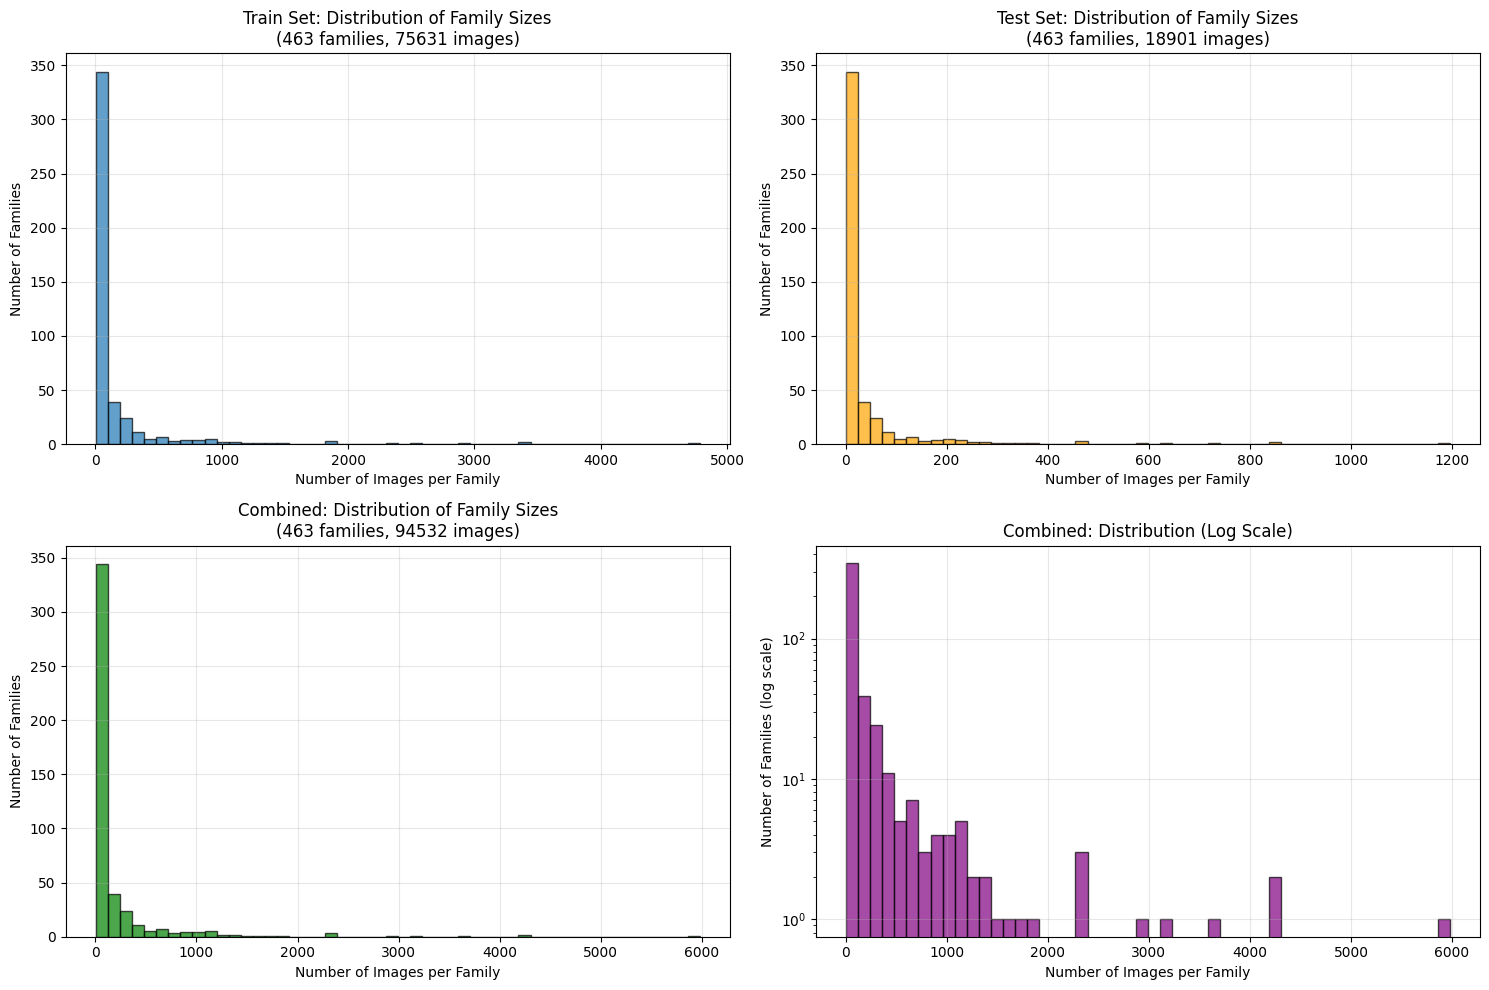


Distribution Statistics:
Train - Min: 4, Max: 4782, Std: 446.24
Test  - Min: 1, Max: 1196, Std: 111.57
Combined - Min: 5, Max: 5978, Std: 557.81


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create histogram of family sizes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Train distribution
axes[0, 0].hist(train_family_counts.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Images per Family')
axes[0, 0].set_ylabel('Number of Families')
axes[0, 0].set_title(f'Train Set: Distribution of Family Sizes\n({len(train_family_counts)} families, {len(train_df)} images)')
axes[0, 0].grid(True, alpha=0.3)

# Test distribution
axes[0, 1].hist(test_family_counts.values, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Number of Images per Family')
axes[0, 1].set_ylabel('Number of Families')
axes[0, 1].set_title(f'Test Set: Distribution of Family Sizes\n({len(test_family_counts)} families, {len(test_df)} images)')
axes[0, 1].grid(True, alpha=0.3)

# Combined distribution
axes[1, 0].hist(combined_family_counts.values, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Number of Images per Family')
axes[1, 0].set_ylabel('Number of Families')
axes[1, 0].set_title(f'Combined: Distribution of Family Sizes\n({len(combined_family_counts)} families, {len(combined_df)} images)')
axes[1, 0].grid(True, alpha=0.3)

# Log scale view for combined
axes[1, 1].hist(combined_family_counts.values, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Number of Images per Family')
axes[1, 1].set_ylabel('Number of Families (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Combined: Distribution (Log Scale)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nDistribution Statistics:")
print(f"Train - Min: {train_family_counts.min()}, Max: {train_family_counts.max()}, Std: {train_family_counts.std():.2f}")
print(f"Test  - Min: {test_family_counts.min()}, Max: {test_family_counts.max()}, Std: {test_family_counts.std():.2f}")
print(f"Combined - Min: {combined_family_counts.min()}, Max: {combined_family_counts.max()}, Std: {combined_family_counts.std():.2f}")

## Summary: Families with Very Few Images

In [12]:
# Detailed analysis of small families
print(f"\n{'='*70}")
print(f"FAMILIES WITH VERY FEW IMAGES - DETAILED BREAKDOWN")
print(f"{'='*70}")

# Check in combined dataset
families_less_than_5 = combined_family_counts[combined_family_counts < 5]
families_exactly_5 = combined_family_counts[combined_family_counts == 5]
families_less_than_10 = combined_family_counts[combined_family_counts < 10]

print(f"\nCombined Dataset (Train + Test):")
print(f"  Families with exactly 1 image:  {len(combined_family_counts[combined_family_counts == 1])}")
print(f"  Families with 2-4 images:       {len(families_less_than_5)}")
print(f"  Families with exactly 5 images: {len(families_exactly_5)}")
print(f"  Families with less than 10:     {len(families_less_than_10)}")

if len(families_less_than_5) > 0:
    print(f"\n⚠️  WARNING: Families with less than 5 images ({len(families_less_than_5)} families):")
    for family, count in sorted(families_less_than_5.items(), key=lambda x: x[1]):
        train_count = train_family_counts.get(family, 0)
        test_count = test_family_counts.get(family, 0)
        print(f"  - {family:40s} {count:2d} total (train: {train_count}, test: {test_count})")

if len(families_exactly_5) > 0:
    print(f"\nFamilies with exactly 5 images ({len(families_exactly_5)} families):")
    for family, count in sorted(families_exactly_5.items()):
        train_count = train_family_counts.get(family, 0)
        test_count = test_family_counts.get(family, 0)
        print(f"  - {family:40s} {count:2d} total (train: {train_count}, test: {test_count})")

# Show families with 5-10 images
families_5_to_10 = combined_family_counts[(combined_family_counts >= 5) & (combined_family_counts <= 10)]
if len(families_5_to_10) > 0:
    print(f"\nFamilies with 5-10 images ({len(families_5_to_10)} families):")
    for family, count in sorted(families_5_to_10.items(), key=lambda x: x[1]):
        train_count = train_family_counts.get(family, 0)
        test_count = test_family_counts.get(family, 0)
        print(f"  - {family:40s} {count:2d} total (train: {train_count}, test: {test_count})")

print(f"\n{'='*70}")
print(f"RECOMMENDATION:")
print(f"{'='*70}")
if len(families_less_than_5) > 0:
    print(f"⚠️  Found {len(families_less_than_5)} families with less than 5 images.")
    print(f"   These families may cause issues with training/validation splits.")
    print(f"   Consider:")
    print(f"   1. Removing these families from the dataset")
    print(f"   2. Collecting more images for these families")
    print(f"   3. Using stratified splitting carefully")
elif len(families_less_than_10) > 0:
    print(f"⚠️  No families with less than 5 images, but {len(families_less_than_10)} families have less than 10.")
    print(f"   These families may have limited representation.")
else:
    print(f"✓ All families have at least 10 images. Good for training!")


FAMILIES WITH VERY FEW IMAGES - DETAILED BREAKDOWN

Combined Dataset (Train + Test):
  Families with exactly 1 image:  0
  Families with 2-4 images:       0
  Families with exactly 5 images: 24
  Families with less than 10:     91

Families with exactly 5 images (24 families):
  - Anoplogastridae                           5 total (train: 4, test: 1)
  - Aplodactylidae                            5 total (train: 4, test: 1)
  - Banjosidae                                5 total (train: 4, test: 1)
  - Caproidae                                 5 total (train: 4, test: 1)
  - Centrogenyidae                            5 total (train: 4, test: 1)
  - Chalceidae                                5 total (train: 4, test: 1)
  - Chaudhuriidae                             5 total (train: 4, test: 1)
  - Derichthyidae                             5 total (train: 4, test: 1)
  - Diplomystidae                             5 total (train: 4, test: 1)
  - Eurypharyngidae                           5 total (

In [13]:
# Quick summary
print("QUICK SUMMARY:")
print(f"Families with exactly 1 image (combined): {len(combined_family_counts[combined_family_counts == 1])}")
print(f"Families with less than 5 images (combined): {len(combined_family_counts[combined_family_counts < 5])}")
print(f"Families with 5-9 images (combined): {len(combined_family_counts[(combined_family_counts >= 5) & (combined_family_counts < 10)])}")
print(f"\nSmallest family size in combined: {combined_family_counts.min()}")
print(f"Smallest family size in train: {train_family_counts.min()}")
print(f"Smallest family size in test: {test_family_counts.min()}")

QUICK SUMMARY:
Families with exactly 1 image (combined): 0
Families with less than 5 images (combined): 0
Families with 5-9 images (combined): 91

Smallest family size in combined: 5
Smallest family size in train: 4
Smallest family size in test: 1


# Task Analysis for Mixture of Experts (MoE)

Analyzing potential tasks for MoE architecture:
1. **Family Classification** (current task - best performance)
2. **Order Classification** (taxonomic hierarchy)
3. **Habitat Classification** (9 binary outputs: Tropical, Temperate, Subtropical, Boreal, Polar, freshwater, saltwater, brackish, FeedingPath)
4. **Trophic Level Prediction** (Troph - continuous or discrete)

In [14]:
# Analyze Order distribution
print("\n" + "="*80)
print("ORDER CLASSIFICATION ANALYSIS")
print("="*80)

order_counts_train = train_df['Order'].value_counts()
order_counts_test = test_df['Order'].value_counts()
order_counts_combined = combined_df['Order'].value_counts()

print(f"\nNumber of unique Orders:")
print(f"  Train: {len(order_counts_train)}")
print(f"  Test: {len(order_counts_test)}")
print(f"  Combined: {len(order_counts_combined)}")

print(f"\nTop 20 Orders by sample count (combined):")
for i, (order, count) in enumerate(order_counts_combined.head(20).items(), 1):
    train_count = order_counts_train.get(order, 0)
    test_count = order_counts_test.get(order, 0)
    print(f"  {i:2d}. {order:30s} {count:5d} total (train: {train_count:4d}, test: {test_count:4d})")

print(f"\nOrder distribution statistics:")
print(f"  Min samples: {order_counts_combined.min()}")
print(f"  Max samples: {order_counts_combined.max()}")
print(f"  Mean samples: {order_counts_combined.mean():.2f}")
print(f"  Median samples: {order_counts_combined.median():.0f}")

orders_less_than_10 = order_counts_combined[order_counts_combined < 10]
print(f"\n⚠️  Orders with < 10 samples: {len(orders_less_than_10)}")
if len(orders_less_than_10) > 0:
    print("  These orders:")
    for order, count in orders_less_than_10.items():
        print(f"    - {order:30s} {count} samples")


ORDER CLASSIFICATION ANALYSIS

Number of unique Orders:
  Train: 92
  Test: 92
  Combined: 92

Top 20 Orders by sample count (combined):
   1. Perciformes                    23108 total (train: 18383, test: 4725)
   2. Cypriniformes                   6780 total (train: 5424, test: 1356)
   3. Eupercaria/misc                 5788 total (train: 4678, test: 1110)
   4. Tetraodontiformes               5499 total (train: 4398, test: 1101)
   5. Ovalentaria/misc                4824 total (train: 3860, test:  964)
   6. Siluriformes                    4523 total (train: 3617, test:  906)
   7. Gobiiformes                     3309 total (train: 2658, test:  651)
   8. Cyprinodontiformes              3003 total (train: 2403, test:  600)
   9. Syngnathiformes                 2724 total (train: 2179, test:  545)
  10. Myliobatiformes                 2321 total (train: 1858, test:  463)
  11. Salmoniformes                   2291 total (train: 1833, test:  458)
  12. Cichliformes                  

In [17]:
# Analyze Habitat/Environment features (binary classification tasks)
print("\n" + "="*80)
print("HABITAT/ENVIRONMENT BINARY CLASSIFICATION ANALYSIS")
print("="*80)

habitat_cols = ['Tropical', 'Temperate', 'Subtropical', 'Boreal', 'Polar', 
                'freshwater', 'saltwater', 'brackish', 'FeedingPath']

# Check which columns exist
available_habitat_cols = [col for col in habitat_cols if col in train_df.columns]
print(f"\nAvailable habitat columns: {available_habitat_cols}")

for col in available_habitat_cols:
    # Count non-null values and distribution
    train_non_null = train_df[col].notna().sum()
    test_non_null = test_df[col].notna().sum()
    combined_non_null = combined_df[col].notna().sum()
    
    # For binary columns, count positive cases
    if col != 'FeedingPath':  # Assuming FeedingPath might be categorical
        # Convert to int to handle any float values
        train_positive = int(train_df[col].sum() if train_df[col].dtype in ['int64', 'float64'] else train_df[col].value_counts().get(1, 0))
        test_positive = int(test_df[col].sum() if test_df[col].dtype in ['int64', 'float64'] else test_df[col].value_counts().get(1, 0))
        combined_positive = int(combined_df[col].sum() if combined_df[col].dtype in ['int64', 'float64'] else combined_df[col].value_counts().get(1, 0))
        
        print(f"\n{col}:")
        print(f"  Non-null samples: {combined_non_null:5d} ({100*combined_non_null/len(combined_df):.1f}%)")
        print(f"  Positive cases:   {combined_positive:5d} ({100*combined_positive/max(combined_non_null,1):.1f}% of non-null)")
        print(f"    Train: {train_positive:5d} / {train_non_null:5d}")
        print(f"    Test:  {test_positive:5d} / {test_non_null:5d}")
    else:
        # FeedingPath might be categorical
        print(f"\n{col}:")
        print(f"  Non-null samples: {combined_non_null:5d} ({100*combined_non_null/len(combined_df):.1f}%)")
        print(f"  Unique values: {combined_df[col].nunique()}")
        print(f"  Value counts:")
        for val, count in combined_df[col].value_counts().head(10).items():
            print(f"    {val}: {count}")


HABITAT/ENVIRONMENT BINARY CLASSIFICATION ANALYSIS

Available habitat columns: ['Tropical', 'Temperate', 'Subtropical', 'Boreal', 'Polar', 'freshwater', 'saltwater', 'brackish', 'FeedingPath']

Tropical:
  Non-null samples: 90147 (95.4%)
  Positive cases:   71172 (79.0% of non-null)
    Train: 56907 / 72132
    Test:  14265 / 18015

Temperate:
  Non-null samples: 90147 (95.4%)
  Positive cases:   58709 (65.1% of non-null)
    Train: 46934 / 72132
    Test:  11775 / 18015

Subtropical:
  Non-null samples: 90147 (95.4%)
  Positive cases:   73213 (81.2% of non-null)
    Train: 58512 / 72132
    Test:  14701 / 18015

Boreal:
  Non-null samples: 90147 (95.4%)
  Positive cases:   14455 (16.0% of non-null)
    Train: 11509 / 72132
    Test:   2946 / 18015

Polar:
  Non-null samples: 90147 (95.4%)
  Positive cases:    4252 (4.7% of non-null)
    Train:  3391 / 72132
    Test:    861 / 18015

freshwater:
  Non-null samples: 90147 (95.4%)
  Positive cases:   40618 (45.1% of non-null)
    Train:


TROPHIC LEVEL (TROPH) ANALYSIS

Non-null Troph values:
  Train: 72132 / 75631 (95.4%)
  Test:  18015 / 18901 (95.3%)
  Combined: 90147 / 94532 (95.4%)

Troph statistics:
  Unique values: 518
  Min: 1.98
  Max: 5.29
  Mean: 3.35
  Std: 0.60
  Median: 3.40

Value distribution (if discrete):
  (Too many unique values - likely continuous)


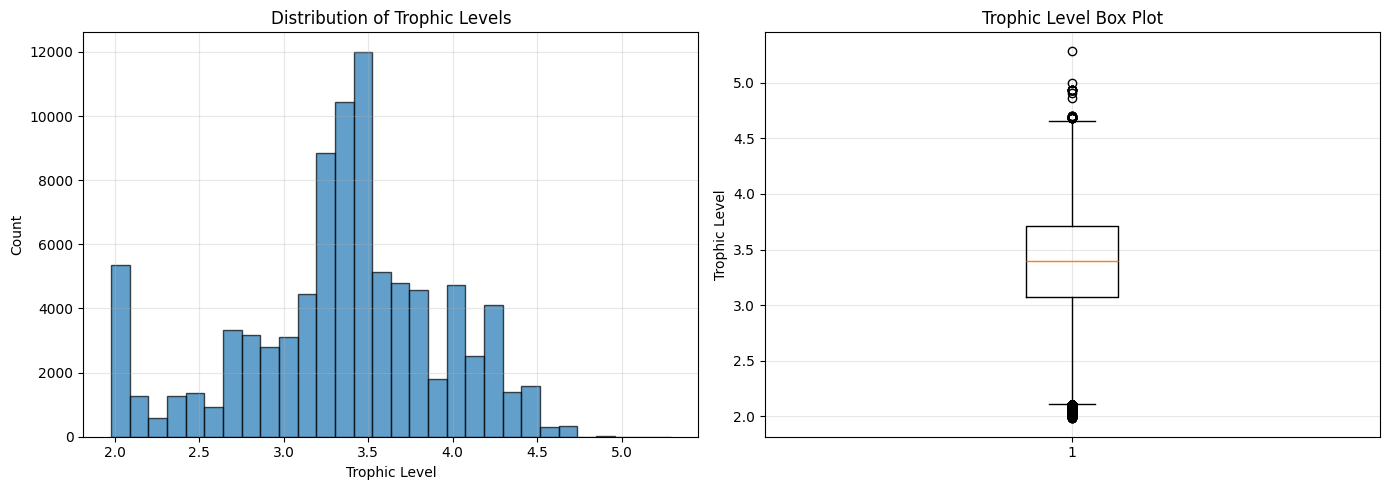

In [16]:
# Analyze Trophic Level (Troph)
print("\n" + "="*80)
print("TROPHIC LEVEL (TROPH) ANALYSIS")
print("="*80)

if 'Troph' in train_df.columns:
    troph_non_null_train = train_df['Troph'].notna().sum()
    troph_non_null_test = test_df['Troph'].notna().sum()
    troph_non_null_combined = combined_df['Troph'].notna().sum()
    
    print(f"\nNon-null Troph values:")
    print(f"  Train: {troph_non_null_train:5d} / {len(train_df):5d} ({100*troph_non_null_train/len(train_df):.1f}%)")
    print(f"  Test:  {troph_non_null_test:5d} / {len(test_df):5d} ({100*troph_non_null_test/len(test_df):.1f}%)")
    print(f"  Combined: {troph_non_null_combined:5d} / {len(combined_df):5d} ({100*troph_non_null_combined/len(combined_df):.1f}%)")
    
    # Check if it's continuous or discrete
    troph_values = combined_df['Troph'].dropna()
    unique_values = troph_values.nunique()
    
    print(f"\nTroph statistics:")
    print(f"  Unique values: {unique_values}")
    print(f"  Min: {troph_values.min():.2f}")
    print(f"  Max: {troph_values.max():.2f}")
    print(f"  Mean: {troph_values.mean():.2f}")
    print(f"  Std: {troph_values.std():.2f}")
    print(f"  Median: {troph_values.median():.2f}")
    
    # Show distribution
    print(f"\nValue distribution (if discrete):")
    if unique_values <= 20:
        for val, count in troph_values.value_counts().sort_index().items():
            print(f"  Troph = {val:.2f}: {count:5d} samples")
    else:
        print("  (Too many unique values - likely continuous)")
        
    # Histogram
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(troph_values, bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Trophic Level')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Trophic Levels')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].boxplot(troph_values)
    axes[1].set_ylabel('Trophic Level')
    axes[1].set_title('Trophic Level Box Plot')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  'Troph' column not found in dataset")